# Inference

Loading /kaggle/input/mlns-1/data0.npy and /kaggle/input/mlns-1/lab0.npy...
Loading /kaggle/input/mlns-1/data1.npy and /kaggle/input/mlns-1/lab1.npy...
Loading /kaggle/input/mlns-1/data2.npy and /kaggle/input/mlns-1/lab2.npy...
Data shape: (30000, 40, 168)
Labels shape: (30000,)


<ipython-input-9-a09b446b05de>:212: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)


Loaded model weights directly.

Val MSE: 0.0252
Val Accuracy (rounded sums): 99.17%



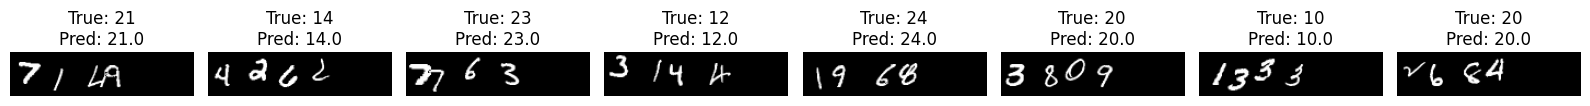

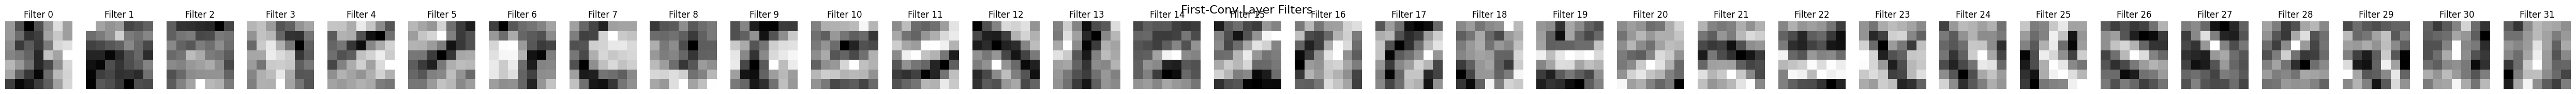

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random

from torch.utils.data import DataLoader, Dataset, random_split
from math import ceil
import os

def load_all_data(data_files, label_files):
    all_data = []
    all_labels = []
    for dfile, lfile in zip(data_files, label_files):
        print(f"Loading {dfile} and {lfile}...")
        data_part = np.load(dfile)
        label_part = np.load(lfile)
        all_data.append(data_part)
        all_labels.append(label_part)

    X = np.concatenate(all_data, axis=0)
    y = np.concatenate(all_labels, axis=0)
    return X, y


class DigitsDataset(Dataset):
    """
    A basic PyTorch Dataset for digit images and their sum labels.

    Args:
        X (numpy.ndarray): Array of shape (N, C, H, W) containing image data.
        y (numpy.ndarray): Array of shape (N,) containing integer labels.

    Returns:
        (tensor, int): Tuple containing the image tensor and its corresponding label.
    """
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        img = self.X[idx]
        label = self.y[idx]
        if len(img.shape) == 2:
            img = np.expand_dims(img, 0)

        img_tensor = torch.from_numpy(img).float()
        return img_tensor, label


class SEBlock(nn.Module):
    """
    Squeeze-and-Excitation (SE) Block from:
    "Squeeze-and-Excitation Networks"
    Jie Hu, Li Shen, Samuel Albanie, Gang Sun, and Enhua Wu.
    https://arxiv.org/abs/1709.01507

    This block performs:
      1. Global Average Pooling (Squeeze step).
      2. Two Fully-Connected layers to learn channel-wise weights (Excitation step).
      3. Rescales the original feature map channels with learned weights.
    """
    def __init__(self, channels, reduction=16):
        super(SEBlock, self).__init__()
        self.fc1 = nn.Linear(channels, channels // reduction)
        self.fc2 = nn.Linear(channels // reduction, channels)
        self.relu = nn.ReLU(inplace=True)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        batch_size, c, h, w = x.size()
        squeeze = x.view(batch_size, c, -1).mean(dim=2)  # (B, C)
        excitation = self.fc1(squeeze)
        excitation = self.relu(excitation)
        excitation = self.fc2(excitation)
        excitation = self.sigmoid(excitation)
        excitation = excitation.view(batch_size, c, 1, 1)
        return x * excitation


class BasicBlockSE(nn.Module):
    """
    Basic ResNet block (2 convolutional layers + skip connection),
    enhanced with a Squeeze-and-Excitation (SE) module.

    Args:
        in_channels (int): Number of input channels.
        out_channels (int): Number of output channels.
        stride (int): Stride size for the first convolution.
        reduction (int): Reduction ratio for the SEBlock.

    Returns:
        torch.Tensor: Output feature map.
    """
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1, reduction=16):
        super(BasicBlockSE, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.se = SEBlock(out_channels, reduction=reduction)

        self.downsample = None
        if stride != 1 or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1,
                          stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        out = self.se(out)

        if self.downsample is not None:
            identity = self.downsample(x)
        out += identity

        out = self.relu(out)
        return out


class SEResNet(nn.Module):
    """
    A small Squeeze-and-Excitation ResNet implementation using the BasicBlockSE.

    Args:
        block (nn.Module): Residual block module to use (BasicBlockSE).
        layers (list of int): Number of blocks in each of the four layers.
        in_channels (int): Number of input channels to the network.
        base_channels (int): Initial number of channels (will get multiplied in deeper layers).
        reduction (int): Reduction ratio for the SEBlock.
        num_classes (int): Number of output classes (here, we predict a single value).

    Returns:
        torch.Tensor: Model output of shape [N, num_classes].
    """
    def __init__(self, block=BasicBlockSE, layers=[2,2,2,2],
                 in_channels=1, base_channels=32,
                 reduction=16, num_classes=1):
        super(SEResNet, self).__init__()
        self.in_channels = base_channels

        # Stem
        self.conv1 = nn.Conv2d(in_channels, base_channels, kernel_size=7,
                               stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(base_channels)
        self.relu = nn.ReLU(inplace=True)
        self.pool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # 4 ResNet layers
        self.layer1 = self._make_layer(block, base_channels, layers[0], stride=1, reduction=reduction)
        self.layer2 = self._make_layer(block, base_channels*2, layers[1], stride=2, reduction=reduction)
        self.layer3 = self._make_layer(block, base_channels*4, layers[2], stride=2, reduction=reduction)
        self.layer4 = self._make_layer(block, base_channels*8, layers[3], stride=2, reduction=reduction)

        # Final head
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        out_channels = base_channels * 8
        self.fc = nn.Linear(out_channels, num_classes)

        self._init_weights()

    def _init_weights(self):
        """
        Initialize model weights using Kaiming and Xavier initialization.
        """
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)

    def _make_layer(self, block, out_channels, blocks, stride, reduction):
        """
        Create a ResNet layer composed of several blocks.

        Args:
            block (nn.Module): The type of block to add.
            out_channels (int): Number of output channels for the block.
            blocks (int): Number of blocks to stack in this layer.
            stride (int): Stride for the first block of the layer.
            reduction (int): Reduction ratio for the SEBlock.

        Returns:
            nn.Sequential: A sequence of blocks forming one ResNet layer.
        """
        layers = []
        layers.append(block(self.in_channels, out_channels, stride=stride, reduction=reduction))
        self.in_channels = out_channels
        for _ in range(1, blocks):
            layers.append(block(out_channels, out_channels, stride=1, reduction=reduction))
        return nn.Sequential(*layers)

    def forward(self, x):
        """
        Forward pass through the SEResNet.

        Args:
            x (torch.Tensor): Input tensor of shape [B, in_channels, H, W].

        Returns:
            torch.Tensor: Output tensor of shape [B, num_classes].
        """
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.pool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        out = self.fc(x)
        return out

def main():
    """
    Inference script:
    - Load the entire dataset (images + labels).
    - Load the trained model from 'best_model_se_resnet.pth'.
    - Run inference on the entire dataset.
    - Compute and display MSE and accuracy (with integer rounding).
    - Show a few sample predictions alongside their images.
    - Optionally visualize the first conv layer filters.
    """
    # ---------------------------
    # LOAD DATA (for inference, just so that it is replacable, i have loaded all the data, this can be replaced with the new test files for checking)
    # ---------------------------
    data_files = ["/kaggle/input/mlns-1/data0.npy",
                  "/kaggle/input/mlns-1/data1.npy",
                  "/kaggle/input/mlns-1/data2.npy"]
    label_files = ["/kaggle/input/mlns-1/lab0.npy",
                   "/kaggle/input/mlns-1/lab1.npy",
                   "/kaggle/input/mlns-1/lab2.npy"]

    X, y = load_all_data(data_files, label_files)
    print("Data shape:", X.shape)
    print("Labels shape:", y.shape)

    if len(X.shape) == 3:
        X = np.expand_dims(X, axis=-1)
    X = np.transpose(X, (0, 3, 1, 2)).astype(np.float32)
    X /= 255.0

    dataset = DigitsDataset(X, y)
    data_loader = DataLoader(dataset, batch_size=8, shuffle=False)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = SEResNet(
        block=BasicBlockSE,
        layers=[2, 2, 2, 2],
        in_channels=1,
        base_channels=32,
        reduction=16,
        num_classes=1
    ).to(device)

    best_model_path = "/kaggle/input/seresnet/pytorch/default/1/best_sum_digits_model_seresnet.pth"  # Path to your best model
    checkpoint = torch.load(best_model_path, map_location=device)

    if "model_state_dict" in checkpoint:
        model.load_state_dict(checkpoint["model_state_dict"])
        print("Loaded 'model_state_dict' from checkpoint.")
    else:
        model.load_state_dict(checkpoint)
        print("Loaded model weights directly.")

    model.eval()

    criterion = nn.MSELoss()
    total_samples = len(dataset)
    total_loss = 0.0
    total_correct = 0
    total_count = 0

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch_x, batch_y in data_loader:
            batch_x = batch_x.to(device)
            batch_y = batch_y.float().to(device)

            preds = model(batch_x).view(-1)
            loss = criterion(preds, batch_y)
            total_loss += loss.item() * batch_x.size(0)

            preds_rounded = torch.round(preds)
            total_correct += (preds_rounded == batch_y).sum().item()
            total_count += len(batch_y)

            all_preds.append(preds_rounded.cpu().numpy())
            all_labels.append(batch_y.cpu().numpy())

    mse_value = total_loss / total_samples
    accuracy = total_correct / total_count

    print(f"\nInference on entire dataset:")
    print(f"Total samples: {total_samples}")
    print(f"MSE: {mse_value:.4f}")
    print(f"Accuracy (integer-rounded): {accuracy*100:.2f}%\n")

    batch_x, batch_y = next(iter(data_loader))
    batch_x_gpu = batch_x.to(device)
    with torch.no_grad():
        preds = model(batch_x_gpu).view(-1)
    preds_rounded = torch.round(preds)

    num_images = min(len(batch_x), 8)
    plt.figure(figsize=(16, 2))
    for i in range(num_images):
        plt.subplot(1, num_images, i+1)
        img_np = batch_x[i].cpu().numpy()
        img_np = np.squeeze(img_np, axis=0)

        plt.imshow(img_np, cmap='gray')
        true_label = batch_y[i].item()
        pred_label = preds_rounded[i].cpu().item()
        plt.title(f"True: {true_label}\nPred: {pred_label}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

    first_conv_weights = model.conv1.weight.data.clone().cpu()
    num_filters = first_conv_weights.shape[0]
    fig, axs = plt.subplots(1, num_filters, figsize=(2*num_filters, 2))
    fig.suptitle("First Conv Layer Filters", fontsize=16)
    for i in range(num_filters):
        kernel = first_conv_weights[i, 0, :, :].numpy()
        axs[i].imshow(kernel, cmap='gray')
        axs[i].set_title(f"Filter {i}")
        axs[i].axis('off')
    plt.show()


if __name__ == "__main__":
    main()